# UK Web Archive Open Data: 'big data' for 'small histories' 

**Note: this is a work in progress. I will keep updating this when I have time. I am still learning Python so the code may contain errors or at the least not be done in the most efficient way.**

The web has been around for over 20 years. As a result is is becoming an increasingly important resource for researchers. This is where web archives have an important role to play. Web archiving has been around for almost as long as the web. Web archives will become an increasingly important resource for historians and other researchers. However, despite the existence of a variety of web archives with extensive collections there are a number of potential barriers and difficulties in making use of web archives.

One of these barriers are the legal restrictions on the creation and use of web archives. In 2003 the Legal Deposit Libraries Act (2003) was extended to cover online publications. This means that the majority of the UK web is now being archived. However, access ['to the whole legal deposit web archive will be possible only on premises controlled by one of the six legal deposit libraries.'](http://www.webarchive.org.uk/ukwa/info/about). The legal deposit collection is complemented with material for which permision has been gained and which is freely available. 

This material can be used in much the same way as might be done for a close reading of 'traditional' non electronic sources. However, web archives also present new oppertunities for interegating collections in new ways. Often this involves 'distant reading' of web archive collections. An example of this type of work is a project being carried out by Ian Milliagan and the ['web archives for historical research group'](https://uwaterloo.ca/web-archive-group/). 

One potential barrier to using big data methods for researchers may be technical - they are not sure how to extract the information they want from a web archive. A related problem though might be that researchers are not sure how to use a web archive 'distantly' if they interested in a history of the web itself (at least not directly). These researchers may benfit from a big data/distant reading approach to questions about a particular institution, rather than looking at a much wider dataset. The UK Web Archive Open Data consists primarily of a variety of metadata about the web, rather than the full text of the websites. This may present an additional barrier to researchers in knowing how this material could still be useful for addressing research questions. This notebook will attempt to suggest some potential approaches that could be taken. 


## UK Web Archive Open Data 

The UK Web Archive makes a number of datasets [available](http://data.webarchive.org.uk/opendata/) on an open basis. This notebook will try to demonstrate how one of these datasets could be used by historians in the manner described above. 

### Host Link Graph - JISC UK Web Domain Dataset (1996-2010)
One of the datasets available contains host link data between 1996 and 2010. This data looks like
```
1996|appserver.ed.ac.uk|portico.bl.uk   1
1996|art-www.acorn.co.uk|portico.bl.uk  1

```
The data is broken into four parts. The first column is the crawl years, the second the source or 'origin' link. The third link contains the 'destination link', the final collumn is the number of linking urls. Essentially this shows at a top level i.e. not a specific page, where a site has linked to. 


### Using this data

A dataset like this can be explored in many different ways. One way would be to explore the whole dataset. However, we may not be primarily interested in the history of the web but are keen to use web archived material as a source. This notebook will try and outline this sort of approach using the Wellcome Trust's web presence as an example. If we were interested in an institutional history of the Wellcome, how researchers funders have interacted with the web or a related question we may want to explore web archives. 


### Issues with the data
There are a number of issues with the dataset that we should be aware of. The primary one relates to the crawler settings used for different years not counting duplicated links between years. This means we should be cautious about using the number of times linked as an authorative number. These issues are discussed more on the datasets [page](http://data.webarchive.org.uk/opendata/ukwa.ds.2/host-linkage/). 


### Getting the data

The first couple of steps will take place outside of this notebook but are fairly straight forward. The first thing we will need to do is to get the data we are going to be working wit. A collection of open data from the internet archive can be found [here](http://data.webarchive.org.uk/opendata/). The dataset we are looking at can be downloaded from [here](http://data.webarchive.org.uk/opendata/ukwa.ds.2/host-linkage/). The file is around 16GB so you may want to consider using a download manager to download the file. A download manager should speed things up a little but also make it easier to deal with any issues during the download. I use [aira](https://aria2.github.io/) but there are other out there. Make sure you have enought room to download the file. 

Once you have the file downloaded on your computer we can do a number of different things. The first thing we want to do is to get data related to the Wellcome out of the dataset. To do this we can modify the grep suggested on the [dataset page](http://data.webarchive.org.uk/opendata/ukwa.ds.2/host-linkage/) replacing the "bl.uk" with "wellcome.ac.uk"

In [ ]:
% zgrep "wellcome.ac.uk" host-linkage.tsv.gz | sort > wellcome-linkage.tsv

This will pull out data relating to the Wellcome and output it as a new file. This may take a while depending on your computer and the size of the data you are extracting. Once we have done this we can begin working with the data. 

In [16]:
## import packages 
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import re as re
import seaborn as sns
import time
## show plots in notebook
%matplotlib inline

### Importing data into Python

First we will want to get our data into Python. 

In [4]:
# get pandas to read tsv table and store in wellcome_data
# use regular expresion to seperate times link number out
# store collumns in 'origin', 'link' and 'times linked' columns
wellcome_data = pd.read_table('wellcome-linkage.tsv', names=['year','origin','link','times-linked'], sep='\||\t', engine='python')


In [5]:
wellcome_data.head(10)

,year,origin,link,times-linked
0,1996,odin.neuro.soton.ac.uk,www.wellcome.ac.uk,1
1,1996,tarantula.wellcome.ac.uk,tarantula.wellcome.ac.uk,24
2,1996,www.ability.org.uk,www.tmr.wellcome.ac.uk,1
3,1996,www.healthindex.co.uk,www.tmr.wellcome.ac.uk,1
4,1997,atuin.chime.ucl.ac.uk,www.wellcome.ac.uk,10
5,1997,back.niss.ac.uk,www.wellcome.ac.uk,1
6,1997,bushmills.mic.dundee.ac.uk,www.wellcome.ac.uk,2
7,1997,com2.uclan.ac.uk,www.wellcome.ac.uk,7
8,1997,epidemic.zoo.ox.ac.uk,www.tmr.wellcome.ac.uk,2
9,1997,garbo.psychol.ucl.ac.uk,www.wellcome.ac.uk,5


The above table shows the first ten rows of our dataset. We can see that some of these links are from other domains linking to the Wellcome Trust domain whilst others are from Wellcome Trust domain going out. We will explore this more below. We can also see in the times linked collumn the number of times this domain is linked from the 'origin' to the 'link' domain. 

### Sorting data by times-linked

Lets now sort by times linked. This will allow us to see which links were linked the most times. 

In [5]:
wellcome_data.sort_values(by='times-linked', ascending=0)[:10]

,year,origin,link,times-linked
14321,2004,www.wellcome.ac.uk,www.wellcome.ac.uk,619077
10467,2003,www.wellcome.ac.uk,www.wellcome.ac.uk,483541
26772,2008,www.wellcome.ac.uk,www.wellcome.ac.uk,247042
17552,2005,www.wellcome.ac.uk,www.wellcome.ac.uk,237786
23856,2007,www.wellcome.ac.uk,www.wellcome.ac.uk,180320
20498,2006,www.wellcome.ac.uk,www.wellcome.ac.uk,169626
10922,2004,library.wellcome.ac.uk,library.wellcome.ac.uk,134802
4921,2001,www.wellcome.ac.uk,www.wellcome.ac.uk,125546
14751,2005,library.wellcome.ac.uk,library.wellcome.ac.uk,114517
31673,2010,www.wellcome.ac.uk,www.wellcome.ac.uk,109542


We can see that a majority of these links are internal links. We should also be cautious with these link numbers because of the way logging of links across years was done (see above). Lets get ride of internal links. 

In [15]:
# loop out internal links. 
links = []
for link in wellcome_data.link:
    if "wellcome" in link :
        links.append(False)
    else:
        links.append(True)
links[0:5]

not_internal_link = pd.Series(links)

In [16]:
wellcome_external_links = wellcome_data[not_internal_link]
wellcome_external_links.head(10)

,year,origin,link,times-linked
98,1997,www.wellcome.ac.uk,www.campus.bt.com,2
99,1997,www.wellcome.ac.uk,www.macromedia.com,3
100,1997,www.wellcome.ac.uk,www.ucl.ac.uk,5
203,1998,tarantula.wellcome.ac.uk,bbsrc.ac.uk,2
204,1998,tarantula.wellcome.ac.uk,bimednet.com,2
205,1998,tarantula.wellcome.ac.uk,biotech.chem.indiana.edu,2
206,1998,tarantula.wellcome.ac.uk,cebm.jr2.ox.ac.uk,2
207,1998,tarantula.wellcome.ac.uk,cnn.com,2
208,1998,tarantula.wellcome.ac.uk,croma.ebi.ac.uk,2
209,1998,tarantula.wellcome.ac.uk,darwin.cshl.org,3


Now we are left with only external links. We can already see that some of this information could potentially be of interest. We can now sort by times-linked for external links. 

#### Most linked external links

In [50]:
wellcome_external_links.sort_values(by="times-linked", ascending=0)[:10]

,year,origin,link,times-linked
26252,2008,www.wellcome.ac.uk,www.facebook.com,2411
25908,2008,www.wellcome.ac.uk,digg.com,2410
25983,2008,www.wellcome.ac.uk,reddit.com,2410
25906,2008,www.wellcome.ac.uk,del.icio.us,2410
26684,2008,www.wellcome.ac.uk,www.stumbleupon.com,2410
25963,2008,www.wellcome.ac.uk,myweb2.search.yahoo.com,2410
31256,2010,www.wellcome.ac.uk,www.facebook.com,1656
31050,2010,www.wellcome.ac.uk,twitter.com,1654
31014,2010,www.wellcome.ac.uk,myweb2.search.yahoo.com,1650
30960,2010,www.wellcome.ac.uk,del.icio.us,1650


We can see that the top links are all for various social media websites. This is maybe not particularly suprising but it might provide a starting point for considering how an organisation like the Wellcome communicates through the web. 

We may also be interested to see whether the top links have changed over time. 


#### How links change over time. 

In [17]:
wellcome_external_links[wellcome_external_links.year==1997].sort_values(by="times-linked", ascending=0)

,year,origin,link,times-linked
100,1997,www.wellcome.ac.uk,www.ucl.ac.uk,5
99,1997,www.wellcome.ac.uk,www.macromedia.com,3
98,1997,www.wellcome.ac.uk,www.campus.bt.com,2


In [18]:
wellcome_external_links[wellcome_external_links.year==1998].sort_values(by="times-linked", ascending=0).head(10)

,year,origin,link,times-linked
360,1998,tarantula.wellcome.ac.uk,www.umds.ac.uk,22
320,1998,tarantula.wellcome.ac.uk,www.ncbi.nlm.nih.gov,10
335,1998,tarantula.wellcome.ac.uk,www.omni.ac.uk,8
239,1998,tarantula.wellcome.ac.uk,www.adobe.com,8
308,1998,tarantula.wellcome.ac.uk,www.mailbase.ac.uk,8
352,1998,tarantula.wellcome.ac.uk,www.shef.ac.uk,8
277,1998,tarantula.wellcome.ac.uk,www.exploratory.org.uk,8
370,1998,tarantula.wellcome.ac.uk,www.who.ch,6
254,1998,tarantula.wellcome.ac.uk,www.bmj.com,6
331,1998,tarantula.wellcome.ac.uk,www.nmsi.ac.uk,6


In [19]:
wellcome_external_links[wellcome_external_links.year==2000].sort_values(by="times-linked", ascending=0).head(10)

,year,origin,link,times-linked
1655,2000,wisdom.wellcome.ac.uk,www.swetsnet.nl,99
2599,2000,www.wellcome.ac.uk,www.ncbi.nlm.nih.gov,24
2361,2000,www.wellcome.ac.uk,www.doh.gov.uk,17
2135,2000,www.wellcome.ac.uk,omni.ac.uk,17
2548,2000,www.wellcome.ac.uk,www.mailbase.ac.uk,15
2735,2000,www.wellcome.ac.uk,www.shef.ac.uk,15
2364,2000,www.wellcome.ac.uk,www.dti.gov.uk,13
2223,2000,www.wellcome.ac.uk,www.ase.org.uk,13
1603,2000,wisdom.wellcome.ac.uk,www.nature.com,12
2718,2000,www.wellcome.ac.uk,www.sanger.ac.uk,12


In [20]:
wellcome_external_links[wellcome_external_links.year==2005].sort_values(by="times-linked", ascending=0).head(10)

,year,origin,link,times-linked
15101,2005,library.wellcome.ac.uk,www.swetswise.com,258
16804,2005,www.wellcome.ac.uk,news.bbc.co.uk,171
17497,2005,www.wellcome.ac.uk,www.thebritishmuseum.ac.uk,166
17308,2005,www.wellcome.ac.uk,www.ncbi.nlm.nih.gov,153
17064,2005,www.wellcome.ac.uk,www.eurekalert.org,143
17427,2005,www.wellcome.ac.uk,www.sanger.ac.uk,140
17435,2005,www.wellcome.ac.uk,www.sciencedaily.com,114
17514,2005,www.wellcome.ac.uk,www.ucl.ac.uk,104
14617,2005,hydra.hinxton.wellcome.ac.uk,www.statcounter.com,102
14612,2005,hydra.hinxton.wellcome.ac.uk,c4.statcounter.com,102


TODO 
* add more commentary on value of the above. 
* visualise chaning links 
* how to follow up links?

## Distribution of links in the dataset

Now we have looked at some of the most linked sites we may be interested in the dataset more broadly. We can visualise how many links there are across the dataset. This will use the number of crawled links for each year, rather than the number of times that domain was linked. 

* number of links to and from the Wellome.ac.uk website. 

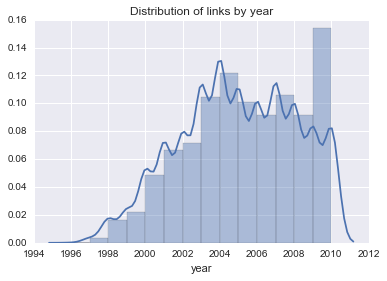

In [23]:
distro = sns.distplot(wellcome_data['year'], bins=14)
distro.set_title('Distribution of links by year')


At the moment this is showing both internal and external links i.e. ones going to and from the Wellcome. Lets just plot links out from the Wellcome. 

### Distribution of external links

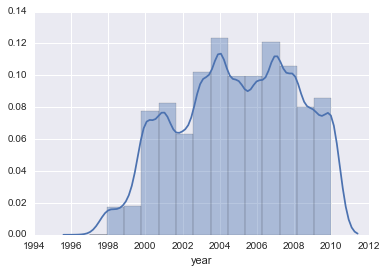

In [11]:
sns.distplot(wellcome_external_links['year'], bins=14)

TODO 
* add commentary on distribution.
* compare to the distribution of the whole dataset - do the distributions vary?

### Comparing links to and from the Wellcome
We might be interested to compare the number of links to and from the Wellcome. 

In [12]:
wellcome_links_out = wellcome_data.origin.str.contains(r'wellcome').sum() 
print("out", wellcome_links_out) 
wellcome_links_in = wellcome_data.link.str.contains(r'wellcome').sum()
print("in",wellcome_links_in)
difference = wellcome_links_out - wellcome_links_in
print(difference)

out 14999
in 17627
-2628


TODO:
- visualise distribution
- compare across years

## Dynamic link visualisation
* This section utilises work by [Andrew Jackson](http://nbviewer.jupyter.org/github/anjackson/keeping-codes/blob/gh-pages/experiments/Visualising%20Link%20Dynamics.ipynb) on visualising this dataset. 

TODO:
- modify code to work with Wellcome data. 
- upload video to youtube

In [ ]:
with open('wellcome-linkage.tsv', 'r') as f:
    for line in f:
        print(line)
        row = line.rstrip().replace('|','\t').split("\t")
        print(row)
        break

In [ ]:
import time

def gource_format(line):
    row = line.rstrip().replace('|','\t').split("\t")
    timestamp = int(time.mktime(time.strptime(row[0], "%Y")))
    hostname = row[1]
    blhost = row[2]
    action = "A"
    colour = "FF0000"
    if( blhost.find("bl.uk") == -1 ):
        hostname = row[2]
        blhost = row[1]
        colour = "0000FF"
    #path = '/'.join(reversed(blhost.split('.')))
    #path = path +'/' + '/'.join(reversed(hostname.split('.')))
    path = '/'.join(reversed(hostname.split('.')))
    return "{}|{}|{}|{}|{}".format(timestamp,hostname,action,path,colour)
    
print(gource_format("1996|appserver.ed.ac.uk|portico.bl.uk	1"))


    

In [ ]:
# Open input and output files
with open('wellcome-linkage.tsv', 'r') as fin:
    with open('wellcome-linkage.log', 'w') as fout:
        counter = 0
        for line in fin:
            # Reformat:
            # for each line gource_format definition used
            new_line = gource_format(line)
            fout.write(new_line)
            fout.write('\n')
            
            # Also count:
            counter = counter + 1
            
            # Report progress:
            if( counter%10000 == 0 ):
                print(counter, line, new_line, '\n')
            
    # Report outcome:
    print("Wrote {} lines.".format(counter))
    fout.close()
    



In [ ]:
# todo - edit code for wellcome example

import time

# Takes a line from the linkage dataset and converts it into the form
# (year, link_path, link_source, link_num)
# Where 'actor' is the host that created the link
def transform_link(line):
    row = line.rstrip().replace('|','\t').split("\t") 
    year = row[0]
    link_source = row[1]
    link_target = row[2]
    host = row[1]
    wellcome_host = row[2]
    link_num = row[3]
    if( blhost.find("wellcome.ac.uk") == -1 ):
        host = row[2]
        wellcome_host = row[1]
    path = '/'.join(reversed(host.split('.')))
    return (year, path, link_source, link_num)

# Open input and output files
known = {}
years = set()
paths = set()
counter = 0
with open('./host-linkage/york-ac-uk-linkage.tsv', 'r') as fin:
     for line in fin:
            try:
                # Reformat:
                (year, path, link_source, link_num) = transform_link(line)
                if( link_source.find("york.ac.uk") == -1 ):
                    link_type = "in"
                else:
                    link_type = "out"
                key = "{}|{}|{}".format(year, path, link_type)
                known[key] = link_num
                years.add(year)
                paths.add(path)
                
            except Exception as e:
                print(e)
                print(line)
                stop
            
            # Also count:
            counter = counter + 1
            
            # Report progress:
            if( counter%10000 == 0 ):
                print(counter, line, key, '\n')
            
# Report outcome:
print("Processed {} lines.".format(counter))

## Other possibilities 
There are a lot of other possibilities for this dataset. 
TODO
- further network analysis 
- comparing with other institutions
- comparing to the dataset as a whole
- follow up links on waybackmachine. Allow for 'close reading'. 